<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/SVIBDN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, Model,load_model
from keras.optimizers import gradient_descent_v2 
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [5]:
!unzip -qq images.zip

In [4]:
!unzip -qq labels.zip

In [6]:
from PIL import Image
from numpy import *
total_img = []
class_label=[]
label = []
files = glob.glob ("images/*.jpg")
for myFile in files:
    image_name=os.path.split(myFile)[1]
    class_label.append(float(image_name[0]))
    image = array(Image.open(myFile))
    label_image = array(Image.open('labels/'+image_name))
    label.append (label_image)
    total_img.append (image)
total_img = np.array(total_img)
label = np.array(label)
class_label=np.array(class_label) 
label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2],label.shape[3]])
total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
np.save('class_labels', class_label)
np.save('total-images',total_img)
np.save('label-images',label)

In [7]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [9]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [8]:
def decoder_network(X):
    #x_input = layers.Input(shape=(147))
    #x = keras.layers.Reshape([7,7,3])(dX)
    x = layers.Conv2DTranspose(2048, (3, 3), strides=2, activation="relu", padding="same")(X)
    x = layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="sigmoid", padding="same")(x)
    output = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="sigmoid", padding="same")(x)
    #model = Model(inputs=X, outputs=output, name='decoder_network')
    return output


In [10]:
def ResNet50():
    #X_input = keras.Input(shape=(224, 224, 3))
    X_input = layers.Input(shape=(224, 224, 3))
    #X = data_augmentation(X_input)
    #X = layers.Rescaling(1./255)(X)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    #7*7*2048
    output1=decoder_network(X)
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    output2 = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs=X_input, outputs=[output1,output2] , name='ResNet50')
    #return output1,output2
    return model

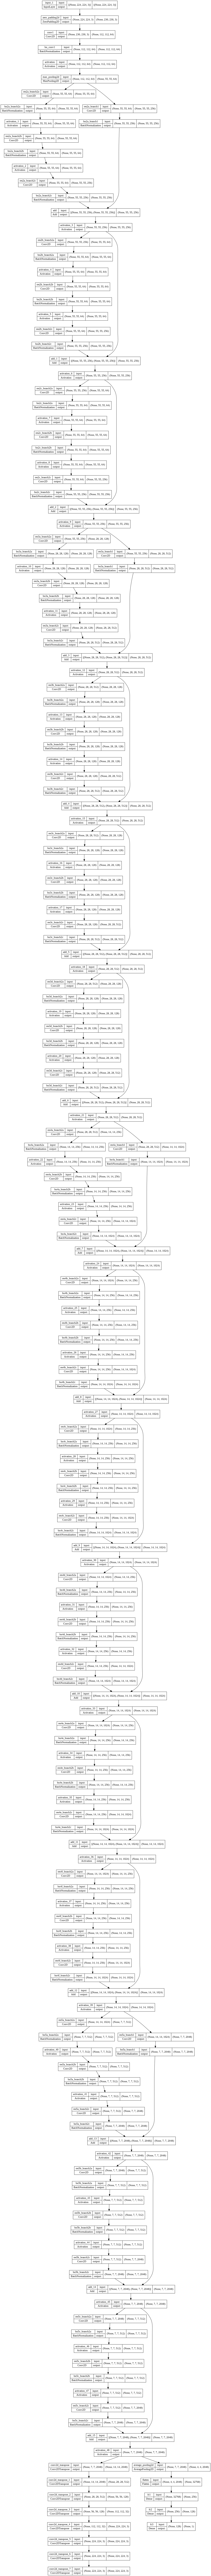

In [11]:
model= ResNet50()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#model = Model(inputs=X_input, outputs=[output1,output2] , name='ResNet50')
#baseModel=ResNet50()
#baseModel.summary()

In [12]:
loss1=tf.keras.losses.MeanSquaredError()
loss2=tf.keras.losses.BinaryCrossentropy()
model.compile(keras.optimizers.Adam(learning_rate=1e-3),loss = [loss1,loss2],)


In [13]:
total_images = np.load('total-images.npy')
total_labels = np.load('label-images.npy')
class_labels=np.load('class_labels.npy')

In [14]:
total_images.shape

(12000, 224, 224, 3)

In [15]:
class_labels.shape

(12000,)

In [16]:
#Training Images 
x_train=total_images[:5000]
y_train=total_labels[:5000]
class_label=class_labels[:5000]
x_train = x_train.astype(np.float32)/ 255.0
y_train=y_train.astype(np.float32)/ 255.0
y_train = ( y_train,class_label)

In [17]:
unique, counts = np.unique(class_label, return_counts=True)


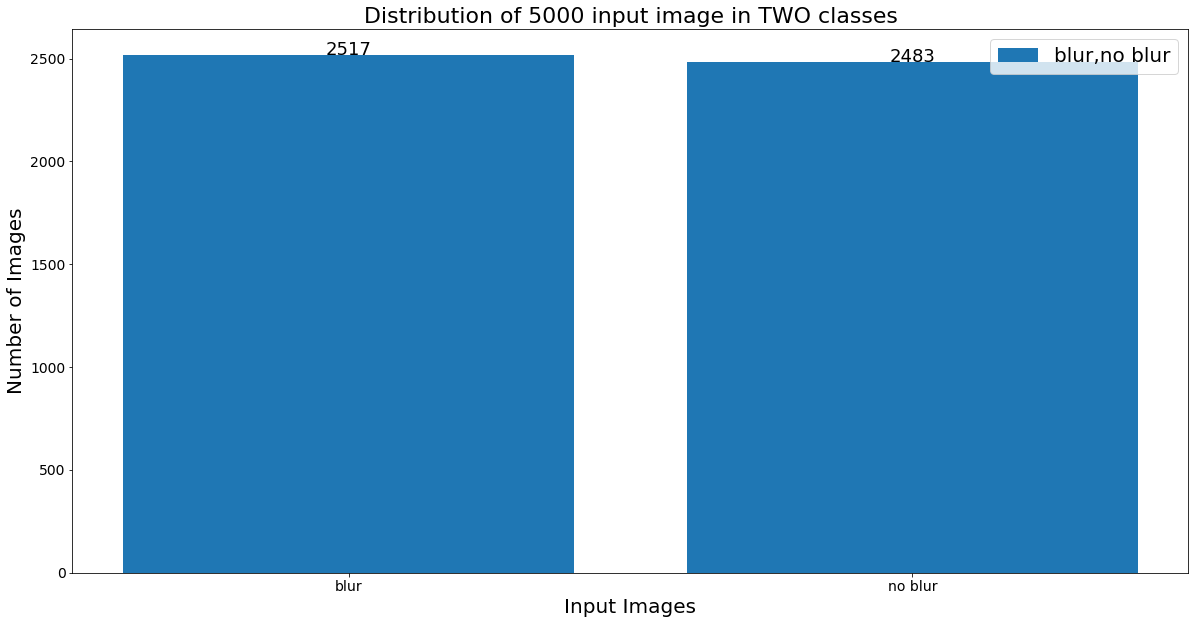

In [68]:
import matplotlib.pyplot as plt
def addlabels(x,y):
	for i in range(len(x)):
		plt.text(i,y[i],y[i],fontsize=18, ha='center')
if __name__ == '__main__':
	# creating data on which bar chart will be plot
	x = ['blur','no blur']
	y = [counts[0],counts[1]]
plt.figure(figsize=(20,10))
plt.bar(x, y,label='blur,no blur')
addlabels(x, y)
plt.title(f"Distribution of {(class_label.shape)[0]} input image in TWO classes",fontsize=22)
plt.xlabel('Input Images',fontsize=20)
plt.ylabel('Number of Images',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().legend(prop={'size': 20})
plt.show()

In [27]:
unique

array([0., 1.])

In [28]:
counts

array([2517, 2483])

In [31]:
## Optimize
history = model.fit(x_train,[y_train[0],y_train[1]], epochs=35,batch_size=20, validation_split=0.2, shuffle=True)
model.save('new_model.h5')

Epoch 1/35
200/200 [==============================] - 73s 281ms/step - loss: 1.7916 - conv2d_transpose_7_loss: 0.1114 - fc3_loss: 1.6802 - val_loss: 0.7712 - val_conv2d_transpose_7_loss: 0.0814 - val_fc3_loss: 0.6897
Epoch 2/35
200/200 [==============================] - 54s 271ms/step - loss: 0.8195 - conv2d_transpose_7_loss: 0.0793 - fc3_loss: 0.7402 - val_loss: 0.8302 - val_conv2d_transpose_7_loss: 0.0802 - val_fc3_loss: 0.7501
Epoch 3/35
200/200 [==============================] - 55s 276ms/step - loss: 0.6176 - conv2d_transpose_7_loss: 0.0786 - fc3_loss: 0.5391 - val_loss: 1.2835 - val_conv2d_transpose_7_loss: 0.0798 - val_fc3_loss: 1.2036
Epoch 4/35
200/200 [==============================] - 54s 271ms/step - loss: 0.3382 - conv2d_transpose_7_loss: 0.0653 - fc3_loss: 0.2730 - val_loss: 1.8142 - val_conv2d_transpose_7_loss: 0.0804 - val_fc3_loss: 1.7339
Epoch 5/35
200/200 [==============================] - 54s 271ms/step - loss: 0.2413 - conv2d_transpose_7_loss: 0.0495 - fc3_loss: 0.

In [32]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'conv2d_transpose_7_loss', 'fc3_loss', 'val_loss', 'val_conv2d_transpose_7_loss', 'val_fc3_loss'])


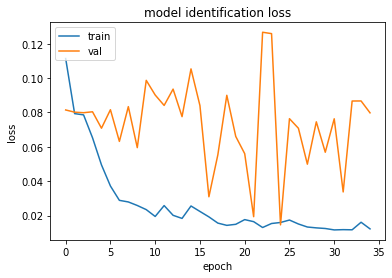

In [34]:
plt.plot(history.history['conv2d_transpose_7_loss'])
plt.plot(history.history['val_conv2d_transpose_7_loss'])
plt.title('model identification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

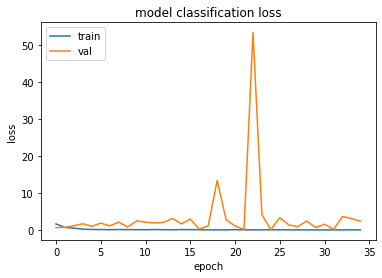

In [35]:
plt.plot(history.history['fc3_loss'])
plt.plot(history.history['val_fc3_loss'])
plt.title('model classification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
#evaluation images
eval_images=total_images[8000:8400]
eval_labels=total_labels[8000:8400]
eval_class_label=class_labels[8000:8400]

In [37]:
from keras.models import load_model
from PIL import Image
#images = np.load('test-blurry-images.npy')
images = eval_images
model = load_model("new_model.h5")
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [ ]:
[eval_class_label[0]]

[1.0]

In [38]:
from statistics import mean
mse_classification=[]
mse_blurDetection=[]
bce_classification=[]
kld_blurDetection=[]
kl = tf.keras.losses.KLDivergence()
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#bce(y_true, y_pred).numpy()
#kl(y_true, y_pred).numpy()
for i in range((images.shape)[0]):
  true_img_class=eval_class_label[i]
  img_pred_class=(((predictions[i])[1])[0])[0]
  true_img_label = eval_labels[i].astype(np.float32)/ 255.0
  img_pred_label= ((predictions[i])[0])[0]
  #mse classification
  mse_classification.append((img_pred_class- true_img_class)**2)
  #mse blur detection
  sb= np. subtract(img_pred_label, true_img_label)
  sq= np. square(sb)
  mseBd = sq.mean()
  mse_blurDetection.append(mseBd)
  #bce classification 
  bce_classification.append(bce([true_img_class],[img_pred_class]).numpy())
  kld_blurDetection.append(kl(true_img_label,img_pred_label).numpy())
MSE_C=mean(mse_classification)
MSE_BD=mean(mse_blurDetection)
BCE_C=mean(bce_classification)
KLD_BD=mean(kld_blurDetection)
print(f" MSE for Model Classification: {MSE_C}")
print(f" MSE for Model Blur area detection: {MSE_BD}")
print(f" BCE for Model Classification: {BCE_C}")
print(f" KLD for Model Blur area detection: {KLD_BD}")

 MSE for Model Classification: 0.2907258833862042
 MSE for Model Blur area detection: 0.073372483253479
 BCE for Model Classification: 0.6565973162651062
 KLD for Model Blur area detection: 0.6711541414260864


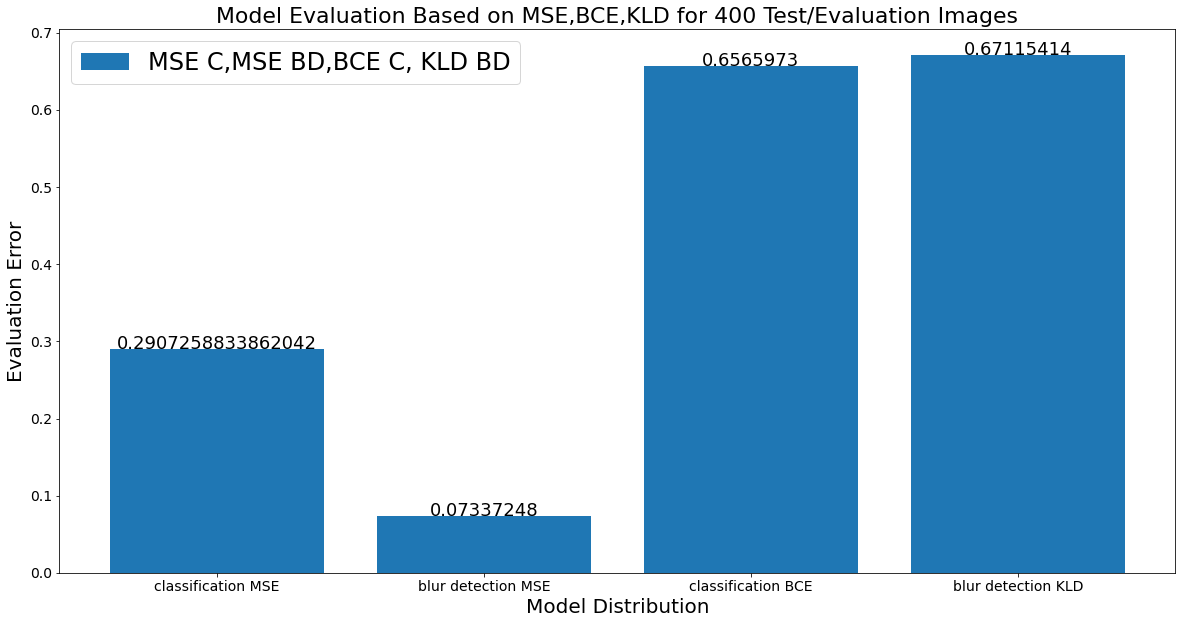

In [51]:
import matplotlib.pyplot as plt
def addlabels(x,y):
	for i in range(len(x)):
		plt.text(i,y[i],y[i],fontsize=18, ha='center')

if __name__ == '__main__':
	# creating data on which bar chart will be plot
	x = ['classification MSE','blur detection MSE','classification BCE','blur detection KLD']
	y = [MSE_C,MSE_BD,BCE_C,abs (KLD_BD)]
plt.figure(figsize=(20,10))
plt.bar(x, y,label='MSE C,MSE BD,BCE C, KLD BD')
addlabels(x, y)
plt.title(f"Model Evaluation Based on MSE,BCE,KLD for {(images.shape)[0]} Test/Evaluation Images",fontsize=22)
plt.xlabel('Model Distribution',fontsize=20)
plt.ylabel('Evaluation Error',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().legend(prop={'size': 24})
plt.show()


predicted class vs true class


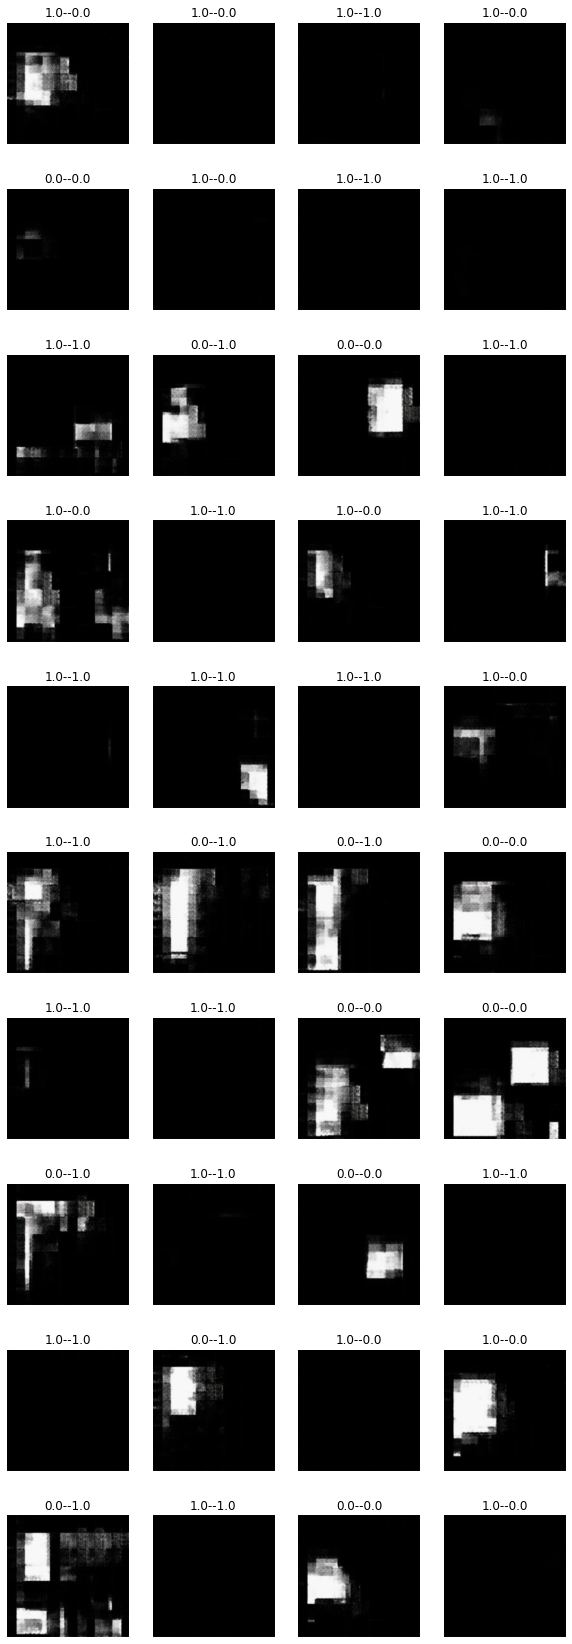

In [40]:
fig = plt.figure(figsize=(10,30))
columns = 4
rows = 10
print("predicted class vs true class")
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(((((predictions[i])[0])[0])*255.0).astype(np.uint8))
  predicted_class=(((predictions[i])[1])[0])[0]
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  plt.title(f"{predicted_class}--{eval_class_label[i]}")
  plt.axis("off")
plt.show()

predicted class vs true class


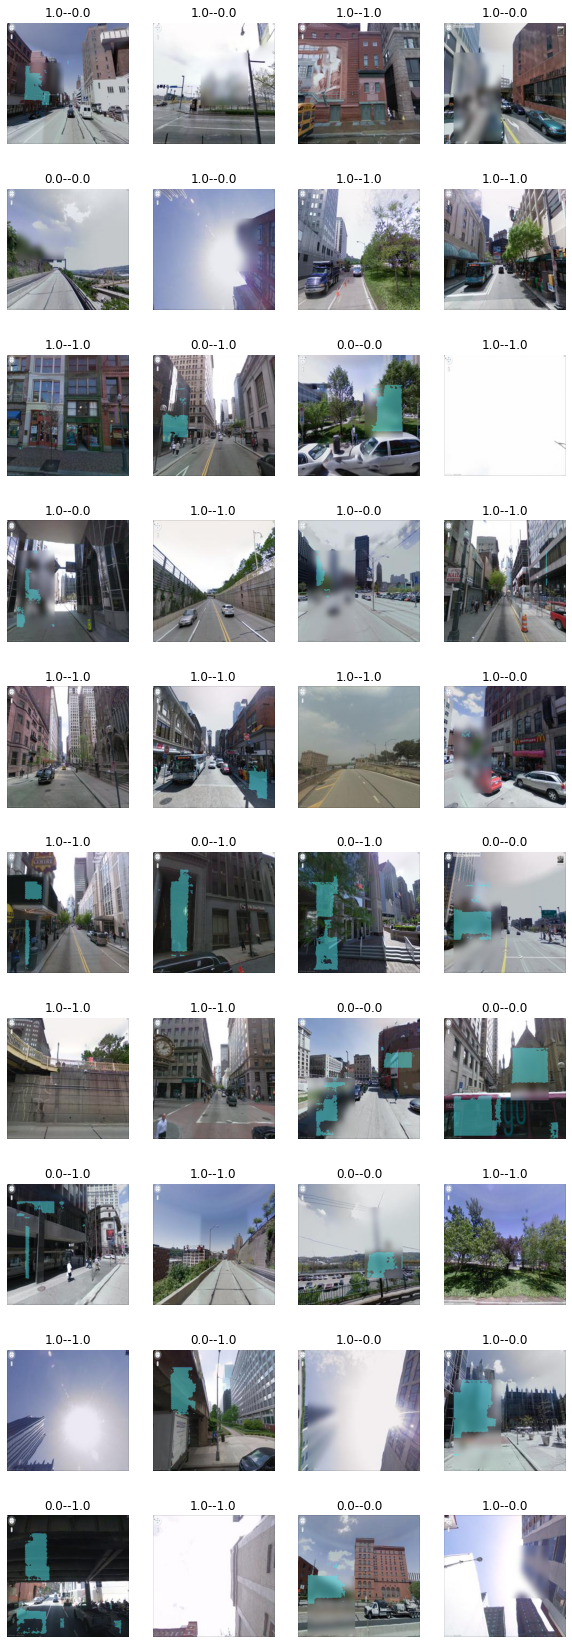

In [65]:
fig = plt.figure(figsize=(10,30))
columns = 4
rows = 10
print("predicted class vs true class")
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  mask=((((predictions[i])[0])[0])*255.0).astype(np.uint8)
  blackFrame = np.zeros((224,224, 3), dtype = "uint8")
  whiteFrame = 255 * np.ones((224,224,3), np.uint8)
  #label_img = Image.fromarray(label_img)
  mask = np.where(mask>=210,whiteFrame,blackFrame)
  img= images[i]
  cyan = np.full_like(img,(80, 229, 235))
  blend = 0.5
  img_cyan = cv2.addWeighted(img, blend, cyan, 1-blend, 0)
  mask = np.where(mask>=165,img_cyan,img)
  #mask =cv2.cvtColor(mask , cv2.COLOR_BGR2RGB)
  plt.imshow(mask,cmap='binary')
  #mask = Image.fromarray(mask)
  predicted_class=(((predictions[i])[1])[0])[0]
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  plt.title(f"{predicted_class}--{eval_class_label[i]}")
  plt.axis("off")
plt.show()

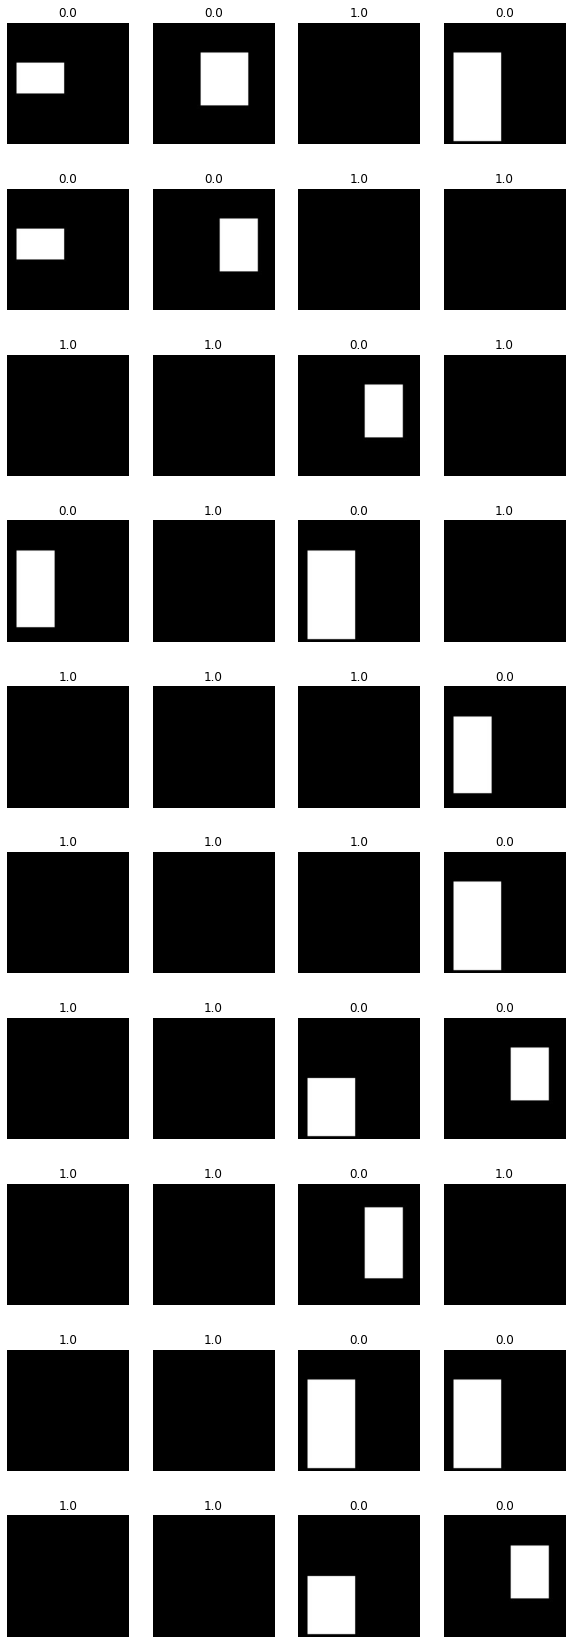

In [41]:
fig = plt.figure(figsize=(10,30))
columns = 4
rows = 10
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(eval_labels[i],cmap='binary')
  plt.title(eval_class_label[i])
  plt.axis("off")
plt.show()

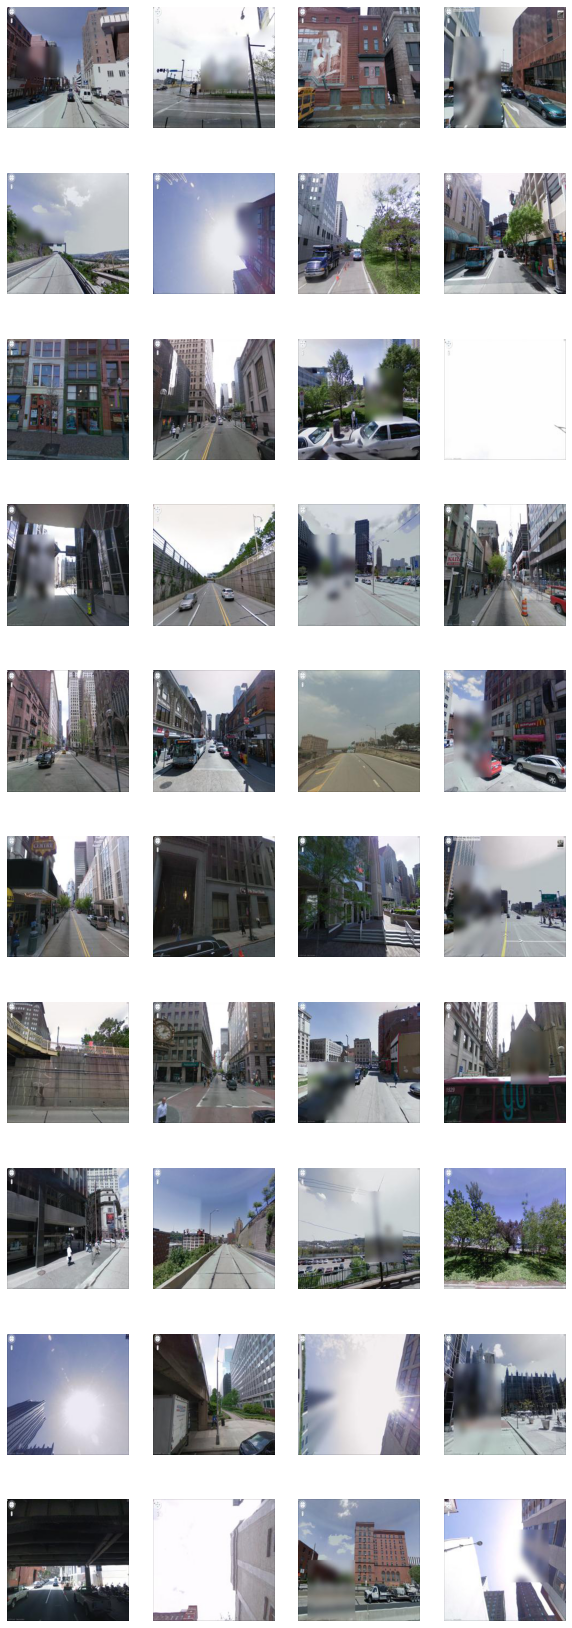

In [42]:
#images = np.load('test-label-images.npy')
#images = images[0:100]
fig = plt.figure(figsize=(10,30))
columns = 4
rows = 10
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(images[i],cmap='binary')
  #plt.title('image')
  plt.axis("off")
plt.show()